## Load Base

In [3]:
from glob import glob
import os
from skimage.io import imread

def load_images(DATABASE_PATH, classes, qtd_imagens=1300):
    database = []
    
    for classe in classes:
        IMAGES_PATH = classe + '/images'

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, IMAGES_PATH, '*.png'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME[0:qtd_imagens]:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)
    
    return database

In [4]:
DATABASE_PATH = '../COVID-19_Radiography_Dataset/'
classes = ['Normal', 'COVID', 'Viral Pneumonia']
database = load_images(DATABASE_PATH, classes, qtd_imagens=1300)

In [5]:
len(database[0]), len(database[1]), len(database[2])

(1300, 1300, 1300)

## Pre Processing

In [6]:
from skimage.filters import laplace
from matplotlib import pyplot as plt

In [7]:
import numpy as np

img = database[0][0]
img_laplace = laplace(img.astype(np.float64))

img_detalhada = img + (1 * img_laplace)

img_detalhada[img_detalhada < 0] = 0
img_detalhada[img_detalhada > 255] = 255

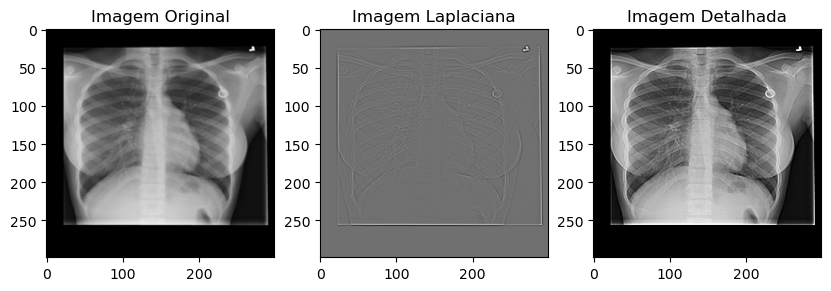

In [8]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
fig.add_subplot(1, 3, 2)
plt.imshow(img_laplace, cmap='gray')
plt.title('Imagem Laplaciana')
fig.add_subplot(1, 3, 3)
plt.imshow(img_detalhada, cmap='gray')
plt.title('Imagem Detalhada');

In [9]:
def make_laplace_database(database):
    laplace_database = []
    for classe in database:
        imagens = []
        for img in classe:
            img_laplace = laplace(img.astype(np.float64))
            img_detalhada = img + img_laplace
            img_detalhada[img_detalhada < 0] = 0
            img_detalhada[img_detalhada > 255] = 255
            imagens.append(img_detalhada)
        laplace_database.append(imagens)
    return laplace_database

In [10]:
new_database = make_laplace_database(database)

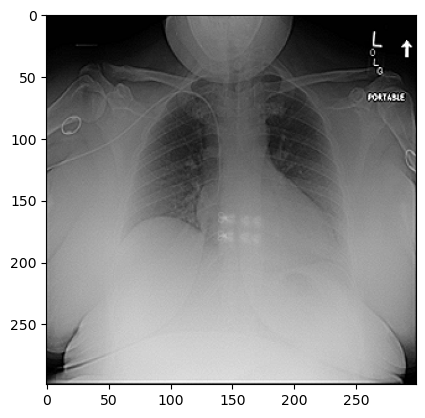

In [11]:
plt.imshow(new_database[0][10], cmap='gray');

## Segmentation

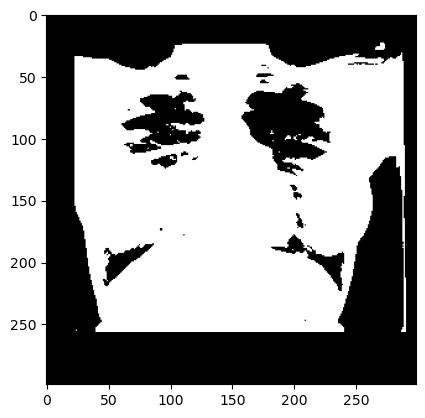

In [12]:
from skimage.filters import threshold_otsu
def make_otsu(img):
    otsu = threshold_otsu(img)
    otsu_img = img > otsu
    return otsu_img
plt.imshow(make_otsu(img), cmap='gray')

In [13]:
def make_segmentation_database(database, function):
    segmentation_database = []
    for classe in database:
        imagens = []
        for img in classe:
            imagens.append(function(img))
        segmentation_database.append(imagens)
    return segmentation_database

In [14]:
segmentation_database = make_segmentation_database(new_database, make_otsu)

In [15]:
def make_ROI_database(database, segmentation_database):
    ROI_database = []
    for classe_database, classe_segmentation in zip(database, segmentation_database):
        imagens = []
        for img, segmentation in zip(classe_database, classe_segmentation):
            imagens.append(img * (1-segmentation))
        ROI_database.append(imagens)
        
    return ROI_database

In [16]:
ROI_database = make_ROI_database(new_database, segmentation_database)

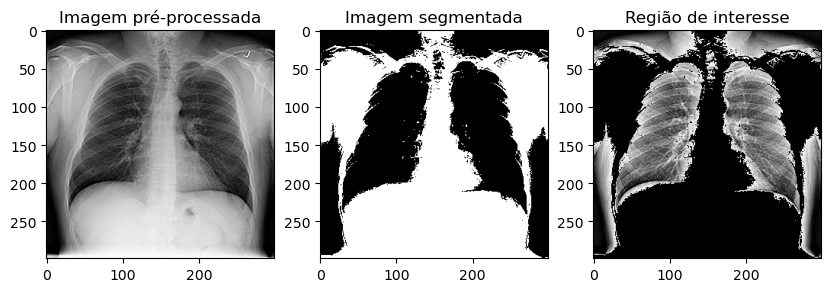

In [17]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(new_database[0][1], cmap='gray')
plt.title('Imagem pré-processada')
fig.add_subplot(1, 3, 2)
plt.imshow(segmentation_database[0][1], cmap='gray')
plt.title('Imagem segmentada')
fig.add_subplot(1, 3, 3)
plt.imshow(ROI_database[0][1], cmap='gray')
plt.title('Região de interesse');


## Descriptors

First

In [18]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis

def energy(x):
    return np.sum(np.power(x, 2))

def descritor_histograma(imagem):
    frequencias, _ = np.histogram(imagem, bins=256, density=True)

    media = np.mean(frequencias)

    var = np.var(frequencias)

    sk = skew(frequencias)

    kur = kurtosis(frequencias)

    ener = energy(frequencias)
    
    entr = entropy(frequencias)

    return [media,var,sk,kur,ener,entr]

In [19]:
print(descritor_histograma(ROI_database[0][0]))

[0.012048192771084336, 0.024799973557222178, 15.889909650296493, 250.66110384731547, 6.385953921605474, 1.2346689560646391]


In [20]:
def matrix_descritors(database, function = None):
    x = []
    y = []
    for classe, images in enumerate(database):
        for image in images:
            x.append(function(image))
            y.append(classe)

    return x,y

In [21]:
x, y = matrix_descritors(ROI_database, function=descritor_histograma)

In [22]:
print(x[0])

[0.012048192771084336, 0.024799973557222178, 15.889909650296493, 250.66110384731547, 6.385953921605474, 1.2346689560646391]


Second

In [23]:
from skimage.feature import graycomatrix, graycoprops

glcm = graycomatrix(ROI_database[0][0].astype(np.int64), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
ASM = graycoprops(glcm, 'ASM')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

print(contrast, dissimilarity, homogeneity, ASM, energy, correlation)

[[191.06064959]] [[3.36284258]] [[0.83869446]] [[0.64048571]] [[0.80030351]] [[0.79116387]]


In [24]:
def to_bool(img):
    return img > 0

In [25]:
def make_graycomatrix(img):
    glcm = graycomatrix(img.astype(np.int64), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    ASM = graycoprops(glcm, 'ASM')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    return [contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0]]

In [26]:
x, y = matrix_descritors(ROI_database, make_graycomatrix)

In [27]:
print(x[0])

[191.06064959260175, 3.3628425849026957, 0.838694463138934, 0.64048571219493, 0.8003035125469149, 0.7911638735341949]


## Classification

In [28]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

In [29]:
metrics = ['accuracy', 'f1_weighted', 'jaccard_weighted']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

First

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [32]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(accuracy_score(y_test, pred))

0.7166666666666667


In [33]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [34]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'n_jobs': [-1]}

In [35]:
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'max_depth': 15, 'n_estimators': 400, 'n_jobs': -1}


In [36]:
rf.set_params(**grid.best_params_)

RandomForestClassifier(max_depth=15, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [37]:
scores = cross_validate(rf, x,y, cv=5, scoring=metrics)

In [38]:
scores

{'fit_time': array([0.59462547, 0.62364864, 0.57073355, 0.58029056, 0.56964588]),
 'score_time': array([0.16290689, 0.1499486 , 0.13528538, 0.15369916, 0.16091037]),
 'test_accuracy': array([0.71538462, 0.67948718, 0.71666667, 0.69358974, 0.70384615]),
 'test_f1_weighted': array([0.71594336, 0.68154461, 0.71641799, 0.6950657 , 0.70406174]),
 'test_jaccard_weighted': array([0.55999999, 0.52271338, 0.56101046, 0.53409286, 0.54670447])}

In [39]:
print('Acuracia: {} (+/- {})'.format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()) )
print('F1: {} (+/- {})'.format(scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()) )
print('Jaccard: {} (+/- {})'.format(scores['test_jaccard_weighted'].mean(), scores['test_jaccard_weighted'].std()) )

Acuracia: 0.7017948717948718 (+/- 0.013964357747887284)
F1: 0.7026066809715286 (+/- 0.013200105914765886)
Jaccard: 0.5449042338282627 (+/- 0.014831405653099048)


Second

In [40]:
from sklearn.neural_network import MLPClassifier as mlp

In [41]:
clf = mlp()
# treinar o classificador
clf.fit(x_train, y_train)
# realizar a predicao
pred = clf.predict(x_test)
# calcular o resultado utilizando a acuracia
accuracy_score(y_test, pred)

0.5064102564102564

In [42]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [43]:
param_grid = {'hidden_layer_sizes': [(50,), (100,), (200,), (300,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'max_iter': [50, 100, 200, 300]}

In [44]:
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(x_train, y_train)
print(grid.best_params_)
clf.set_params(**grid.best_params_)

{'activation': 'logistic', 'hidden_layer_sizes': (200,), 'max_iter': 300}


MLPClassifier(activation='logistic', hidden_layer_sizes=(200,), max_iter=300)

In [45]:
scores = cross_validate(clf, x, y, cv=5, scoring=metrics)

In [46]:
scores

{'fit_time': array([3.17101598, 4.77603984, 3.79071069, 2.63532233, 2.99444413]),
 'score_time': array([0.01102567, 0.00799751, 0.01499033, 0.01499081, 0.00699592]),
 'test_accuracy': array([0.48076923, 0.51410256, 0.63974359, 0.58461538, 0.62820513]),
 'test_f1_weighted': array([0.45751046, 0.51178472, 0.6412365 , 0.5858386 , 0.62169286]),
 'test_jaccard_weighted': array([0.30081635, 0.35631832, 0.47486318, 0.41535469, 0.45585843])}

In [47]:
print('Acuracia: {} (+/- {})'.format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()) )
print('F1: {} (+/- {})'.format(scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()) )
print('Jaccard: {} (+/- {})'.format(scores['test_jaccard_weighted'].mean(), scores['test_jaccard_weighted'].std()) )

Acuracia: 0.5694871794871795 (+/- 0.06253151736553988)
F1: 0.5636126275753199 (+/- 0.06904574641563314)
Jaccard: 0.40064219371580806 (+/- 0.06434881737790231)
